In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
def get_xy(df, response):
    y = df[response]
    x = df.iloc[:, df.columns != response]
        
    return x, y

In [21]:
dataReg = {'age': [10,23,34,21,22,45,32,np.nan,48,32], 'type': ['A','B','C','B','D',np.nan,'A','B',np.nan,'C'],
          'group':['AA','CC','BB','DD',np.nan,np.nan,'AA','BB','CC','BB'], 'child':[1,2,0,np.nan,3,4,2,1,3,2], 
          'wage':[100,200,300,250,200,340,210,320,400,120]}

dataCla = {'age': [10,23,34,np.nan,np.nan,45,32,17,48,32], 'type': ['A','B','C','B','D',np.nan,'A','B',np.nan,'C'],
          'group':['AA','CC','BB','DD',np.nan,np.nan,'AA','BB','CC','BB'], 'child':[1,2,0,1,3,4,2,1,3,np.nan], 
          'result':[1,1,1,0,0,0,0,1,1,1]}
dataReg = pd.DataFrame(dataReg)
dataCla = pd.DataFrame(dataCla)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x="type", y="wage", data=dataReg)

In [14]:
testReg = {'age': [10,23,34,21,22,45,32,17,48,32], 'type': ['A','E','C','B','D',np.nan,'A','B',np.nan,'C'],
          'group':['AA','CC','BB','DD',np.nan,np.nan,'AA','BB','CC','BB'], 'child':[1,2,0,1,3,4,2,1,3,2]}
testReg = pd.DataFrame(testReg)
testReg = testReg.fillna('unknown')

In [15]:
dataReg = dataReg.fillna('unknown')
dummy_train = pd.get_dummies(dataReg)
dummy_new = pd.get_dummies(testReg)

In [18]:
dummy_new = dummy_new.reindex(columns = dummy_train.columns, fill_value=0)

In [19]:
dummy_new

,age,child,wage,group_AA,group_BB,group_CC,group_DD,group_unknown,type_A,type_B,type_C,type_D,type_unknown
0,10,1,0,1,0,0,0,0,1,0,0,0,0
1,23,2,0,0,0,1,0,0,0,0,0,0,0
2,34,0,0,0,1,0,0,0,0,0,1,0,0
3,21,1,0,0,0,0,1,0,0,1,0,0,0
4,22,3,0,0,0,0,0,1,0,0,0,1,0
5,45,4,0,0,0,0,0,1,0,0,0,0,1
6,32,2,0,1,0,0,0,0,1,0,0,0,0
7,17,1,0,0,1,0,0,0,0,1,0,0,0
8,48,3,0,0,0,1,0,0,0,0,0,0,1
9,32,2,0,0,1,0,0,0,0,0,1,0,0


In [17]:
def get_matrix(x, impute_strategy, output_format):
    numeric_df = x.select_dtypes(include=[np.number])
    category_df = x.select_dtypes(include=[object])
    category_df = category_df.fillna('unknown')
    num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_df.columns)),
        ('imputer', Imputer(strategy=impute_strategy)),
        ('std_scaler', StandardScaler())
    ])
    
    if output_format == 'matrix':
        num_result = num_pipeline.fit_transform(numeric_df)
        category_df = category_df.apply(LabelEncoder().fit_transform)
        ohe = OneHotEncoder()
        ohe_result = ohe.fit_transform(category_df).toarray()
        result = np.hstack([num_result, ohe_result])
    elif output_format == 'df':
        num_result = pd.DataFrame(num_pipeline.fit_transform(numeric_df))
        num_result.columns = numeric_df.columns
        category_result = pd.get_dummies(category_df)
        result = pd.concat([num_result, category_result], axis=1)
    
    return result

In [23]:
from sklearn.model_selection import train_test_split
def split_train_test_validation(df, response, test_size = 0.2):
    X, Y = get_xy(df, response)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [31]:
x, y = get_xy(dataCla, 'result')

In [40]:
x_matrix = get_matrix(x, 'median', 'matrix')

In [41]:
X_train, X_test, y_train, y_test = split_train_test(x_matrix,y,test_size=0.2)

In [37]:
def get_baseline_model(X_train, y_train, problem_type, metric):
    kfold = KFold(n_splits=5, random_state=42)
    
    if problem_type == 'regression':
        print 'Linear Regression:', -np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=kfold, scoring=metric))
    elif problem_type == 'classification':
        print 'Logistic Regression:', np.mean(cross_val_score(LogisticRegression(), X_train, y_train, cv=kfold, scoring=metric))

In [28]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

def compare_model(X_train, y_train, problem_type, metric):
    kfold = KFold(n_splits=5, random_state=42)
    cv_performance = []
    
    if problem_type == 'regression':
        algoList = ['LinearRegression', 'Lasso', 'Ridge', 'RandomForestRegressor', 'GradientBoostingRegressor']
        for algo in [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), GradientBoostingRegressor()]:
            cv_performance.append(np.mean(cross_val_score(algo, X_train, y_train, cv=kfold, scoring=metric)))
        result_dict = dict(zip(algoList, cv_performance))
    elif problem_type == 'classification':
        algoList = ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'GradientBoostingClassifier']
        for algo in [LogisticRegression(), SVC(C=0.5), RandomForestClassifier(), GradientBoostingClassifier()]:
            cv_performance.append(np.mean(cross_val_score(algo, X_train, y_train, cv=kfold, scoring=metric)))
        result_dict = dict(zip(algoList, cv_performance))
    return result_dict

SyntaxError: invalid syntax (<ipython-input-28-de0675739cdd>, line 6)

In [42]:
print get_baseline_model(X_train, y_train, 'classification', 'accuracy')

Logistic Regression: 0.6
None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11abeb650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119d6ffd0>]], dtype=object)

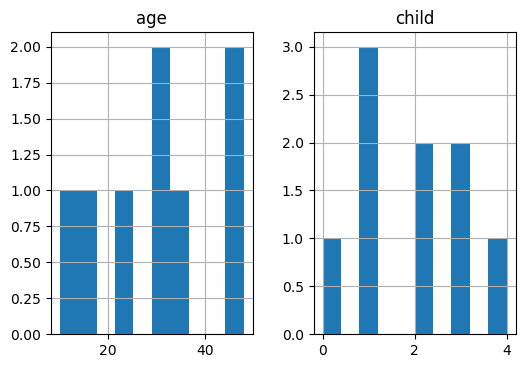

In [45]:
%matplotlib inline
x.hist()